In [ ]:
#%pip install wfdb
#%pip install tqdm
#%pip install tensorflow
#%pip install seaborn

In [4]:
import numpy as np, sys,os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
import wfdb
import tarfile
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import StratifiedKFold
from keras.preprocessing.sequence import pad_sequences
import math
import warnings
import os
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from scipy import signal
from tqdm import tqdm
import json

In [5]:
class OsdbDataLoader:
    def __init__(self, file_path, sampling_rate=25):
        self.file_path = file_path  # Path to the JSON file
        self.sampling_rate = sampling_rate  # Sampling rate (Hz)
        self.df_sensordata = None  # To store the processed DataFrame
        
    def load_data(self):
        """Load and flatten the JSON data into a DataFrame."""
        with open(self.file_path, 'r') as file:
            raw_json = json.load(file)
        
        flattened_data = []
        for attribute in raw_json:
            datapoints = attribute.get('datapoints', [])
            subType = attribute.get('subType', None)

            
            for point in datapoints:
                event_id = point.get('eventId', None)
                rawData = point.get('rawData', [])
                flattened_data.append({
                    'eventId': event_id,
                    'subType': subType,
                    'rawData': rawData
                })
        
        # Convert to DataFrame
        self.df_sensordata = pd.DataFrame(flattened_data)
        
        # Add a sequential 'Id' column
        self.df_sensordata['Id'] = range(len(self.df_sensordata))
    

    def process_data(self):
        """Process the data through all stages and return the final DataFrame."""
        # Step 1: Load the data
        self.load_data()
        # Step 6: Ensure the DataFrame is sorted by 'Id' column
        self.df_sensordata.sort_values(by='Id', inplace=True)
        self.df_sensordata.reset_index(drop=True, inplace=True)

        return self.df_sensordata

In [10]:
file_path = '../../../tests/testData/testDataVisualisation.json'  # Replace with your JSON file path
dataLoader = OsdbDataLoader(file_path)
df_result = dataLoader.process_data()
df_result.sample()

,eventId,subType,rawData,Id
951,6761,Aura,"[1504, 1517, 1510, 1506, 1498, 1503, 1506, 150...",951


In [11]:
# Create a new DataFrame to store the transformed data
processed_data = []

# Iterate over the DataFrame rows
for idx, row in df_result.iterrows():
    # Extract eventId and subType
    event_id = row['eventId']
    sub_type = row['subType']
    Id = row['Id']
    
    # Extract the rawData (assuming it's a list of 125 values)
    raw_data = row['rawData']
    
    # Create a new row: [eventId, subType, rawData[0], rawData[1], ..., rawData[124]]
    new_row = [event_id, sub_type, Id] + raw_data
    
    # Append the new row to the processed data list
    processed_data.append(new_row)

# Convert processed data into a DataFrame
processed_df = pd.DataFrame(processed_data, columns=['eventId', 'subType', 'Id'] + [f'{i+1}' for i in range(125)])

# Display the resulting DataFrame
print(processed_df.shape)  # Check the shape of the DataFrame
processed_df.head()  # Display the first few rows

(1666, 128)


,eventId,subType,Id,1,2,3,4,5,6,7,...,116,117,118,119,120,121,122,123,124,125
0,407,Other,0,1496.0,1480.0,1500.0,1492.0,1496.0,1484.0,1500.0,...,1484.0,1476.0,1492.0,1496.0,1476.0,1484.0,1496.0,1484.0,1496.0,1484.0
1,407,Other,1,1492.0,1508.0,1496.0,1476.0,1484.0,1476.0,1496.0,...,1504.0,1500.0,1476.0,1484.0,1480.0,1492.0,1504.0,1496.0,1484.0,1492.0
2,407,Other,2,1488.0,1496.0,1484.0,1492.0,1492.0,1508.0,1504.0,...,1500.0,1500.0,1508.0,1488.0,1476.0,1484.0,1476.0,1496.0,1492.0,1496.0
3,407,Other,3,1488.0,1476.0,1480.0,1504.0,1496.0,1508.0,1484.0,...,1500.0,1480.0,1480.0,1496.0,1488.0,1492.0,1476.0,1492.0,1492.0,1500.0
4,407,Other,4,1504.0,1488.0,1504.0,1492.0,1484.0,1500.0,1496.0,...,1496.0,1488.0,1488.0,1476.0,1476.0,1492.0,1508.0,1476.0,1492.0,1480.0


In [12]:
# Step 1: Extract the columns containing the data (excluding eventId and subType)
data_points = processed_df.iloc[:, 3:].values  # :3 ~ first 3 columns using iloc

# Step 2: Calculate the target dimensions based on the number of data columns
n_rows = data_points.shape[0]  
n_columns = data_points.shape[1]  # 125 datapoint columns

features_per_timestep = 125
timesteps = n_columns // features_per_timestep  # Calculate the number of timesteps

# Step 3: Reshape the data_points to match the desired 3D array
reshaped_data = data_points.reshape(n_rows, timesteps, features_per_timestep)

# Step 4: Extract the eventId and subType columns for separate use (not part of the reshaped data)
event_id_and_subtype = processed_df[['eventId', 'subType', 'Id']].values 

# Check the reshaped data shape
print(f"Reshaped Data Shape: {reshaped_data.shape}")  # Print shape
print(f"First entry of reshaped data: \n{reshaped_data[0]}")  # Example entry in the reshaped array



Reshaped Data Shape: (1666, 1, 125)
First entry of reshaped data: 
[[1496. 1480. 1500. 1492. 1496. 1484. 1500. 1492. 1492. 1488. 1496. 1492.
  1492. 1504. 1472. 1488. 1480. 1484. 1476. 1484. 1484. 1488. 1476. 1468.
  1484. 1492. 1508. 1480. 1492. 1492. 1484. 1484. 1492. 1492. 1504. 1488.
  1476. 1476. 1472. 1480. 1480. 1488. 1472. 1480. 1484. 1488. 1504. 1480.
  1480. 1488. 1484. 1500. 1520. 1500. 1492. 1476. 1496. 1488. 1484. 1488.
  1488. 1488. 1484. 1496. 1480. 1480. 1480. 1508. 1484. 1520. 1492. 1468.
  1504. 1484. 1496. 1500. 1464. 1492. 1484. 1480. 1480. 1488. 1484. 1476.
  1500. 1488. 1504. 1488. 1500. 1480. 1500. 1472. 1500. 1488. 1508. 1492.
  1484. 1504. 1496. 1492. 1500. 1500. 1480. 1488. 1488. 1476. 1492. 1500.
  1504. 1480. 1496. 1500. 1484. 1484. 1484. 1484. 1476. 1492. 1496. 1476.
  1484. 1496. 1484. 1496. 1484.]]


C:\Users\jamie\AppData\Local\Temp\ipykernel_16992\952563326.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)


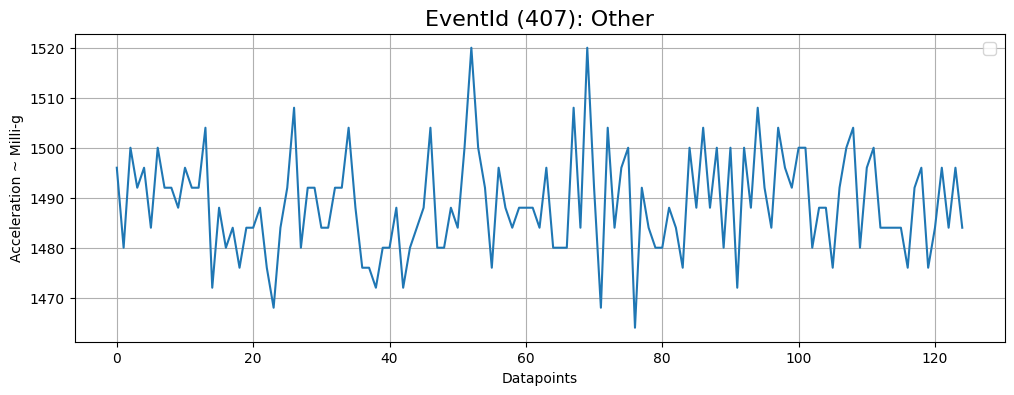

In [ ]:
import matplotlib.pyplot as plt

index = 0 

# Get the eventId and subType from the original DataFrame for this index
event_id = processed_df.loc[index, 'eventId']
sub_type = processed_df.loc[index, 'subType']

# Flatten the first timestep data from reshaped_data
plt.figure(figsize=(12, 4))
plt.title(f"EventId ({event_id}): {sub_type}", fontsize=16)  # Title with eventId and subType

# Plot the first sample's 125 features
plt.plot(reshaped_data[index].flatten())  # Flatten the array to 1D (125,)
plt.xlabel("Datapoints")
plt.ylabel("Acceleration ~ Milli-g")
plt.grid(True)
plt.legend(fontsize=12)
plt.show()


In [14]:
# generate n real samples with class labels
def generate_real_samples(timestep_signal,n):
    """Randomly pick n timesteps from the dataset and return it together with an array of n ones """
    # generate inputs in [-0.5, 0.5]
    X = timestep_signal[np.random.choice(timestep_signal.shape[0],n)]
    # generate class labels
    y = tf.ones((n, 1))
    return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    """Generate random numbers used as input to the generator """
    # generate points in the latent space
    x_in = np.random.randn(latent_dim*n).reshape(n,latent_dim)
    # reshape into a batch of inputs for the proposed model
    return np.expand_dims(x_in,1)
 
def generate_fake_samples(generator, latent_dim, n_samples):
    latent_points = generate_latent_points(latent_dim, n_samples)
    # Reshape latent_points to include the sequence length dimension
    latent_points = latent_points.reshape((n_samples, 1, latent_dim))
    X = generator.predict(latent_points)
    y = np.zeros((n_samples, 1))
    return X, y


def denormalize(fake_data, min_val, x_real):
    #Denormalize fake data back to the original range in mill-g
    fake_data = tf.cast(fake_data, tf.float32)  # Ensure fake_data is float32
    min_val = tf.cast(min_val, tf.float32)      # Ensure min_val is float32
    x_real = tf.cast(x_real, tf.float32)        # Ensure x_real is float32

    if tf.reduce_min(fake_data) < 0:  # If GAN outputs in [-1, 1]
        fake_data = (fake_data + 1) / 2  # Scale to [0, 1]

    # Calculate the dynamic range from x_real
    dynamic_range = tf.reduce_max(x_real) - tf.reduce_min(x_real)

    # Scale to the original range using min_val and dynamic range
    return fake_data * dynamic_range + min_val


def compare_real_and_gen_timestep(generated_timestep):
    """Plot real and generated Raw data plots side by side"""
    plt.figure(figsize=(24,4))
    plt.subplot(1,2,1)
    plt.title("Generated (fake) RawData", fontsize=16)
    plt.plot(generated_timestep[0,:,0])
    plt.subplot(1,2,2)
    plt.title(f"EventId ({event_id}): {sub_type}", fontsize=16)  # Title with eventId and subType
    plt.plot(reshaped_data[index].flatten())  # Flatten the array to 1D (125,)
    plt.show()
    

In [15]:
import tensorflow as tf

def _inception_module(
    input_tensor,
    stride=1,
    activation="linear",
    use_bottleneck=True,
    kernel_size=40,
    bottleneck_size=64,  # Increased bottleneck size
    nb_filters=64,       # Increased number of filters
):
    if use_bottleneck and int(input_tensor.shape[-1]) > 1:
        input_inception = tf.keras.layers.Conv1D(
            filters=bottleneck_size,
            kernel_size=1,
            padding="same",
            activation=activation,
            use_bias=False,
        )(input_tensor)
    else:
        input_inception = input_tensor

    kernel_size_s = [kernel_size // (2**i) for i in range(3)]

    conv_list = []
    for i in range(len(kernel_size_s)):
        conv_list.append(
            tf.keras.layers.Conv1D(
                filters=nb_filters,
                kernel_size=kernel_size_s[i],
                strides=stride,
                padding="same",
                activation=activation,
                use_bias=False,
            )(input_inception)
        )

    max_pool_1 = tf.keras.layers.MaxPool1D(pool_size=3, strides=stride, padding="same")(
        input_tensor
    )

    conv_6 = tf.keras.layers.Conv1D(
        filters=nb_filters,
        kernel_size=1,
        padding="same",
        activation=activation,
        use_bias=False,
    )(max_pool_1)

    conv_list.append(conv_6)

    x = tf.keras.layers.Concatenate(axis=2)(conv_list)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation="relu")(x)
    return x

def _shortcut_layer(input_tensor, out_tensor):
    shortcut_y = tf.keras.layers.Conv1D(
        filters=int(out_tensor.shape[-1]), kernel_size=1, padding="same", use_bias=False
    )(input_tensor)
    shortcut_y = tf.keras.layers.BatchNormalization()(shortcut_y)

    x = tf.keras.layers.Add()([shortcut_y, out_tensor])
    x = tf.keras.layers.Activation("relu")(x)
    return x

def discriminator(
    input_shape=(125, 1),
    nb_classes=1,
    depth=3,               # Increased depth
    use_residual=True,
) -> tf.keras.models.Model:
    input_layer = tf.keras.layers.Input(input_shape)

    x = input_layer
    input_res = input_layer

    for d in range(depth):
        x = _inception_module(x)
        if use_residual and d % 3 == 2:
            x = _shortcut_layer(input_res, x)
            input_res = x

    gap_layer = tf.keras.layers.GlobalAveragePooling1D()(x)

    output_layer = tf.keras.layers.Dense(units=nb_classes, activation="sigmoid")(
        gap_layer
    )

    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),  # Changed loss function
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001),  # Adjusted learning rate
        metrics=[tf.keras.metrics.BinaryAccuracy()],
    )

    return model

desc = discriminator()
print("Discriminator architecture:")
desc.summary()


Discriminator architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 125, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 125, 1)    │          0 │ input_layer[0][0] │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 125, 64)   │      2,560 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 125, 64)   │      1,280 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 125, 64)   │        640 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 125, 64)   │         64 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 125, 256)  │          0 │ conv1d[0][0],     │
│ (Concatenate)       │                   │            │ conv1d_1[0][0],   │
│                     │                   │            │ conv1d_2[0][0],   │
│                     │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 125, 256)  │      1,024 │ concatenate[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 125, 256)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 125, 64)   │     16,384 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 125, 256)  │          0 │ activation[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 125, 64)   │    163,840 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 125, 64)   │     81,920 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 125, 64)   │     40,960 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 125, 64)   │     16,384 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 125, 256)  │          0 │ conv1d_5[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_6[0][0],   │
│                     │                   │            │ conv1d_7[0][0],   │
│                     │                   │            │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 256)  │      1,024 │ concatenate_1[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 125, 256)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 648,129 (2.47 MB)

 Trainable params: 646,081 (2.46 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [16]:
desc = discriminator()
print("Discriminator architecture:")
print(desc.summary())

Discriminator architecture:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 125, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 125, 1)    │          0 │ input_layer_1[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 125, 64)   │      2,560 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 125, 64)   │      1,280 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 125, 64)   │        640 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 125, 64)   │         64 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 125, 256)  │          0 │ conv1d_15[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_16[0][0],  │
│                     │                   │            │ conv1d_17[0][0],  │
│                     │                   │            │ conv1d_18[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 256)  │      1,024 │ concatenate_3[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 125, 256)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 125, 64)   │     16,384 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 125, 256)  │          0 │ activation_4[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_20 (Conv1D)  │ (None, 125, 64)   │    163,840 │ conv1d_19[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_21 (Conv1D)  │ (None, 125, 64)   │     81,920 │ conv1d_19[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_22 (Conv1D)  │ (None, 125, 64)   │     40,960 │ conv1d_19[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_23 (Conv1D)  │ (None, 125, 64)   │     16,384 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 125, 256)  │          0 │ conv1d_20[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_21[0][0],  │
│                     │                   │            │ conv1d_22[0][0],  │
│                     │                   │            │ conv1d_23[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 256)  │      1,024 │ concatenate_4[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 125, 256)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 648,129 (2.47 MB)

 Trainable params: 646,081 (2.46 MB)

 Non-trainable params: 2,048 (8.00 KB)

None


In [17]:
import tensorflow as tf

def generator():
    model = tf.keras.Sequential()

    # Input layer: 1 timestep with 125 datapoints per timestep
    model.add(tf.keras.layers.Dense(125, use_bias=False, input_shape=(1, 125)))  # 125 features (1, 125)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))  # Adjusted alpha for better gradient flow

    # Reshape layer to maintain the 125 features as the second dimension (125, 1)
    model.add(tf.keras.layers.Reshape((125, 1)))  # Output shape (125, 1) for 125 datapoints per timestep
    assert model.output_shape == (None, 125, 1)  # Output shape: (batch_size, 125, 1)

    # First Conv1DTranspose layer
    model.add(tf.keras.layers.Conv1DTranspose(128, 5, strides=1, padding='same', use_bias=False))
    assert model.output_shape == (None, 125, 128)
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))  # Reduced momentum for more stable updates
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))  # Consistent alpha adjustment

    # Second Conv1DTranspose layer
    model.add(tf.keras.layers.Conv1DTranspose(64, 5, strides=1, padding='same', use_bias=False))
    assert model.output_shape == (None, 125, 64)
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    # Third Conv1DTranspose layer (keeping 125 timesteps, 1 feature per timestep)
    model.add(tf.keras.layers.Conv1DTranspose(1, 5, strides=1, padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 125, 1)  # Output shape: (batch_size, 125, 1)

    return model


In [18]:
gen = generator()
print("Generator architecture:")
print(gen.summary())

Generator architecture:


c:\Users\jamie\Desktop\Projects\OpenSeizureDatabase\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\jamie\Desktop\Projects\OpenSeizureDatabase\.venv\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 1, 125)         │        15,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 1, 125)         │           500 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 1, 125)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 125, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 125, 128)       │           640 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 125, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 125, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 125, 64)        │        40,960 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 125, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 125, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_2              │ (None, 125, 1)         │           320 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,813 (229.74 KB)

 Trainable params: 58,179 (227.26 KB)

 Non-trainable params: 634 (2.48 KB)

None


Epoch 0/1
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


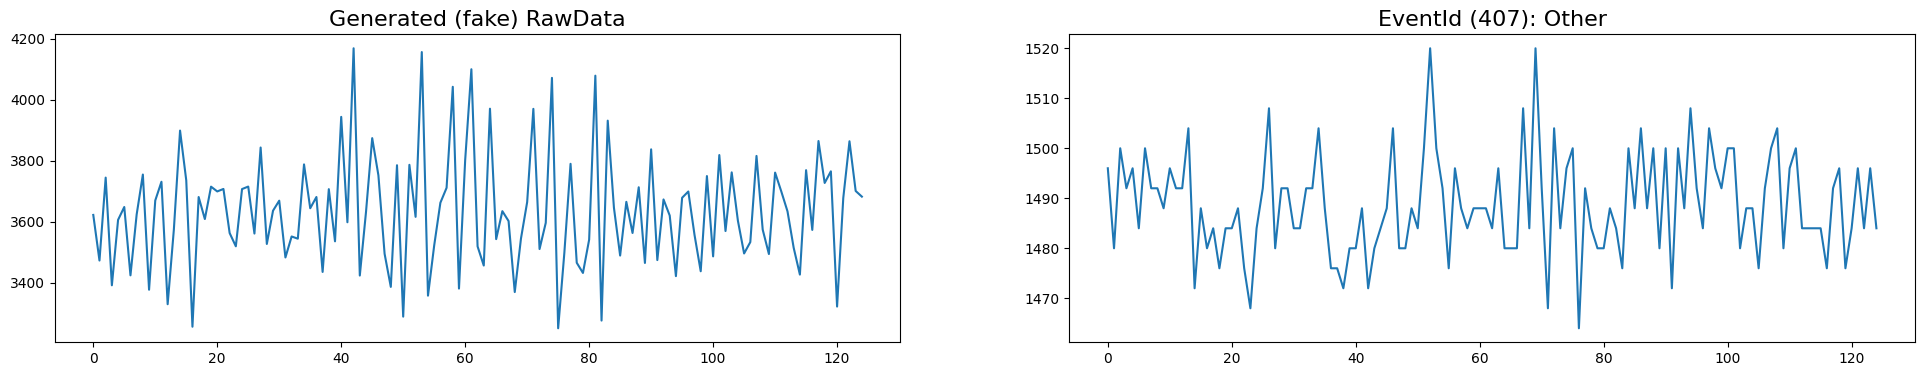

Generator AUROC: 0.0
Generator loss: 0.69430065
Discriminator AUROC: 1.0
Discriminator loss: 0.3475641
-------------------


In [19]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import roc_auc_score

# Define latent dimension and batch size
batch_size = 128
latent_dim = 125
steps = len(reshaped_data) // batch_size
half_batch = batch_size // 2
epochs = 1

# Define optimizers
init_lr_desc = 0.00002
init_lr_gen = 0.00004
opt_desc = tf.keras.optimizers.Adam(learning_rate=init_lr_desc, beta_1=0.5, beta_2=0.9)
opt_gen = tf.keras.optimizers.Adam(learning_rate=init_lr_gen, beta_1=0.5, beta_2=0.9)

# Training loop
for epoch in range(epochs):
    if epoch % 5 == 0:  # Learning rate adjustment every 5 epochs
        init_lr_desc /= 2
        init_lr_gen /= 2
        opt_desc.lr = init_lr_desc
        opt_gen.lr = init_lr_gen

    accu_loss_gan = []
    accu_loss_desc = []
    print(f"Epoch {epoch}/{epochs}")

    for step in range(steps):
        # Generate real and fake samples
        x_real, y_real = generate_real_samples(reshaped_data, half_batch)
        x_fake, y_fake = generate_fake_samples(gen, latent_dim, half_batch)

        # Ensure x_fake has the same shape as x_real
        if x_fake.shape != x_real.shape:
            x_fake = x_fake.reshape(x_real.shape)

        # Store original x_real for later denormalization comparison
        x_real_original = x_real.copy()

        # Combine real and fake samples
        X_train = np.vstack([x_real, x_fake])
        X_train = np.transpose(X_train, (0, 2, 1))
        y_train = np.vstack([y_real, y_fake])

        # Shuffle the combined data
        p = np.random.permutation(len(y_train))
        X_train, y_train = X_train[p], y_train[p]

        # Update discriminator
        with tf.GradientTape() as tape:
            pred_desc = desc(X_train)
            loss_desc = tf.keras.losses.binary_crossentropy(y_train, pred_desc)
        accu_loss_desc.append(loss_desc)
        grads = tape.gradient(loss_desc, desc.trainable_variables)
        opt_desc.apply_gradients(zip(grads, desc.trainable_variables))

        # Update generator
        with tf.GradientTape() as tape:
            x_latent = generate_latent_points(latent_dim, batch_size)  # Generate latent points
            x_gan = gen(x_latent)  # Generate fake data

            # Denormalize the generated fake data (for consistency in plotting/comparison)
            x_gan_denormalized = denormalize(x_gan, tf.reduce_min(x_real_original), x_real_original)

            y_gan = np.ones((batch_size, 1))  # Labels for generated data
            pred_gan = desc(x_gan)  # Use normalized data for training discriminator
            loss_gan = tf.keras.losses.binary_crossentropy(y_gan, pred_gan)
        accu_loss_gan.append(loss_gan)
        grads = tape.gradient(loss_gan, gen.trainable_variables)
        opt_gen.apply_gradients(zip(grads, gen.trainable_variables))

    # Output statistics every 5 epochs
    if epoch % 5 == 0:
        res = gen(generate_latent_points(latent_dim, 1))  # Generate a new batch
        res_denormalized = denormalize(res, tf.reduce_min(x_real_original), x_real_original)  # Denormalize before plotting
        compare_real_and_gen_timestep(res_denormalized)

    # Calculate AUROC and loss for generator and discriminator
    print("Generator AUROC:", roc_auc_score(np.concatenate([y_gan.ravel(), np.array([0])]), 
                                            np.concatenate([np.asarray(pred_gan).ravel(), np.array([0.5])])))

    # Calculate AUROC and loss for discriminator
    print("Generator loss:", np.mean(np.asarray(accu_loss_gan)))
    print("Discriminator AUROC:", roc_auc_score(y_train.ravel(), np.asarray(pred_desc).ravel()))
    print("Discriminator loss:", np.mean(np.asarray(accu_loss_desc)))
    print("-------------------")